# **DOWNLOAD LIBRARAYS**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

import os
import pandas as pd
from sklearn.utils import shuffle


from transformers import AutoTokenizer
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from sklearn.preprocessing import LabelEncoder
from transformers import AdamW, BertForSequenceClassification, BertTokenizer,  DistilBertTokenizer, DistilBertForSequenceClassification, RobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

False
cpu


# **DOWNLOAD DATA**

# 645


In [48]:
# PATH = '/kaggle/input/articles/Data/Task 1/Media 645 (1)'
# PATH = 'C://Users//user//Desktop//Data//Task 1//Media 2728 (2)'
PATH = 'C://Users//user//Desktop//Data//Task 1//Media 645 (1)'

if os.path.exists(PATH):
    print("file exists")
else:
    print("file not exists")

#List of files from each news agency
json_files = [f for f in os.listdir(PATH) if f.endswith('.json')]
# json_files = shuffle(json_files, random_state=42)
all_data = pd.DataFrame()
#We take the required number _ of files
n_json_files = json_files[:]


file exists


We need to take the necessary amount of data and present it in the form of a dataframe to make it convenient for processing

In [50]:
%%time
def process_json_file(json_file):
    df = pd.read_json(os.path.join(PATH, json_file))
    if 'articles' in df.columns:
        articles_df = df['articles'].apply(pd.Series)
        df = df.drop('articles', axis=1)
        df = pd.concat([df, articles_df], axis=1)
    d = {'leftcenter': 'left-center', 'rightcenter': 'right-center'}
    df['bias'] = df['bias'].replace(d)
    return df


data_frames = []
for json_file in tqdm(n_json_files):
    df = process_json_file(json_file)
    data_frames.append(df)
all_data = pd.DataFrame()
all_data = pd.concat(data_frames, ignore_index=True)
all_data = all_data[['name', 'fact', 'bias', 'text', 'id']]
all_data.dropna(subset=['text'], inplace=True)
print(f'The data has been successfully loaded.\nSize: {all_data.shape}')

100%|██████████| 633/633 [04:10<00:00,  2.53it/s]  


The data has been successfully loaded.
Size: (150917, 5)
CPU times: total: 2min 56s
Wall time: 4min 35s


In [51]:
print(all_data.shape)

(150917, 5)


In [52]:
all_data['num_words'] = all_data['text'].apply(lambda x: len(x.split() + x.split('-')))

In [94]:
all_data.head()

,name,fact,bias,text,id,num_words
0,American Center for Law & Justice,mixed,right,We’ve detected that you’re using Internet Expl...,7e9b796c,2351
1,adelaidenow.com.au,mixed,right,10 Rare Coins that are very rarely available i...,3c77894e,1750
2,adelaidenow.com.au,mixed,right,Welcome to WordPress. This is your first post....,8d881c13,263
3,adelaidenow.com.au,mixed,right,10 Rare Coins that are very rarely available i...,bccdae4b,1750
4,adelaidenow.com.au,mixed,right,The AdvertiserSpecial EditionsInsightLiftouts ...,f8459b94,8660


C:\Users\user\AppData\Local\Temp\ipykernel_7964\851390922.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


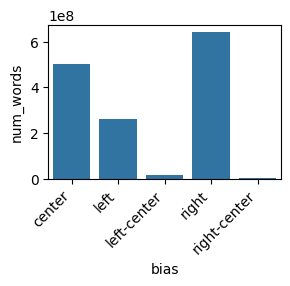

C:\Users\user\AppData\Local\Temp\ipykernel_7964\851390922.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


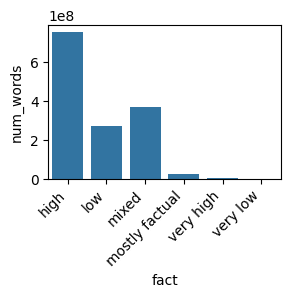

In [149]:
COLUMNS_FOR_ANALYSIS = ['bias', 'fact']
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS)['num_words'].sum().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.show()


In [11]:
def cut(df, col, val, n):
    current_count_uproxx = df[df[col] == val].shape[0]

    df_uproxx = df[df[col] == val]
    df_others = df[df[col] != val]

    desired_count = current_count_uproxx // n

    df_uproxx_downsampled = df_uproxx.sample(n=desired_count, random_state=42)  
    all_data_balanced = pd.concat([df_uproxx_downsampled, df_others])

    print(f"Total 'Uproxx' after downsampling: {all_data_balanced[all_data_balanced[col] == val].shape[0]}")
    print(f"Total 'Other': {all_data_balanced[all_data_balanced[col] != val].shape[0]}")

    return all_data_balanced

In [150]:
all_data_balanced = cut(all_data, 'bias', 'right', 7)
all_data_balanced = cut(all_data_balanced, 'bias', 'left', 2)
all_data_balanced = cut(all_data_balanced, 'bias', 'center', 5)
all_data_balanced = cut(all_data_balanced, 'fact', 'high', 8)
all_data_balanced = cut(all_data_balanced, 'fact', 'low', 2)
all_data_balanced = cut(all_data_balanced, 'fact', 'mixed', 3)


Total 'Uproxx' after downsampling: 9774
Total 'Other': 82496
Total 'Uproxx' after downsampling: 13661
Total 'Other': 64947
Total 'Uproxx' after downsampling: 10514
Total 'Other': 26036
Total 'Uproxx' after downsampling: 2725
Total 'Other': 14744
Total 'Uproxx' after downsampling: 1989
Total 'Other': 13491
Total 'Uproxx' after downsampling: 3194
Total 'Other': 5898


In [1]:
COLUMNS_FOR_ANALYSIS = ['bias', 'fact']
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data_balanced.groupby(COLUMN_FOR_ANALYSIS)['num_words'].sum().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.show()

NameError: name 'all_data_balanced' is not defined

In [152]:
label_bias_order_mapping = {
    "left": 0,
    "left-center": 1,
    "center": 2,
    "right-center": 3,
    "right": 4
}

label_fact_order_mapping = {
    "very low": 0,
    "low": 1,
    "mixed": 2,
    "mostly factual": 3,
    "high": 4,
    "very high" : 5
}

all_data_balanced['bias'] = all_data_balanced['bias'].map(label_bias_order_mapping)
all_data_balanced['fact'] = all_data_balanced['fact'].map(label_fact_order_mapping)
all_data_balanced['bias_fact'] =  all_data_balanced.apply(lambda row: [row['bias'], row['fact']], axis=1)

In [153]:
def clean_text_vectorized(text_series):
    # Remove URLs
    text_no_urls = text_series.str.replace(r'http\S+|www\.\S+', '', regex=True)
    # Remove punctuation marks
    text_no_punctuation = text_no_urls.str.replace(r'[^\w\s]', '', regex=True)
    # Remove HTML
    text_no_html = text_no_punctuation.str.replace(r'<.*?>', '', regex=True)
    return text_no_html

all_data_balanced['text'] = clean_text_vectorized(all_data_balanced['text'])

In [158]:
all_data_balanced.shape

(9092, 7)

# tokenizer

In [155]:
device = "cuda"

In [159]:
def clean_text_vectorized(text_series):
    # Remove URLs
    text_no_urls = text_series.str.replace(r'http\S+|www\.\S+', '', regex=True)
    # Remove punctuation marks
    text_no_punctuation = text_no_urls.str.replace(r'[^\w\s]', '', regex=True)
    # Remove HTML
    text_no_html = text_no_punctuation.str.replace(r'<.*?>', '', regex=True)
    return text_no_html

def tokenize_and_chunk(text, tokenizer, max_chunk_length=256):
    # Tokenize the text without converting to IDs yet to properly handle chunking with special tokens
    tokenized_text = tokenizer.tokenize(text)
    # Initialize an empty list to store token ID chunks
    chunks = []
    # Calculate the actual chunk length accounting for special tokens
    adjusted_chunk_length = max_chunk_length - 2  # Subtracting the space for [CLS] and [SEP]
    for i in range(0, len(tokenized_text), adjusted_chunk_length):
        # Extract the chunk of tokenized text
        chunk = tokenized_text[i:i + adjusted_chunk_length]
        # Convert chunk to IDs with special tokens
        chunk_ids = tokenizer.convert_tokens_to_ids(['[CLS]'] + chunk + ['[SEP]'])
        #padding
        padding_length = max_chunk_length - len(chunk_ids)
        chunk_ids.extend([tokenizer.pad_token_id] * padding_length)
        chunks.append(chunk_ids)
    return chunks

def ids_to_tokens(ids, tokenizer):
    token = tokenizer.convert_ids_to_tokens(ids)
    return token

def create_attention_masks(input_ids):
    return [[float(i > 0) for i in seq] for seq in input_ids]

In [160]:
all_data_distilbert= all_data_balanced.copy()
tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
expanded_rows = []
total_rows = all_data_distilbert.shape[0]

for _, row in tqdm(all_data_distilbert.iloc[0:total_rows,:].iterrows(), total=total_rows):
    chunks = tokenize_and_chunk(row['text'], tokenizer_distilbert)
    for chunk in chunks:
        expanded_rows.append({'name': row['name'], 'bias': row['bias'], 'fact': row['fact'], 'bias_fact': row['bias_fact'], 'text_chunk' : chunk})

distilbert_all_data_ids = pd.DataFrame(expanded_rows)
distilbert_all_data_ids.to_csv('D://DL_coursework//task1//distilbert.csv', index=False)

100%|██████████| 9092/9092 [34:31<00:00,  4.39it/s]   


In [161]:
all_data_bert= all_data_balanced.copy()
tokenizer_bert = BertTokenizer.from_pretrained('bert-large-uncased')
expanded_rows = []
total_rows = all_data_bert.shape[0]

for _, row in tqdm(all_data_bert.iloc[0:total_rows,:].iterrows(), total=total_rows):
    chunks = tokenize_and_chunk(row['text'], tokenizer_bert)
    for chunk in chunks:
        expanded_rows.append({'name': row['name'], 'bias': row['bias'], 'fact': row['fact'], 'bias_fact': row['bias_fact'], 'text_chunk' : chunk})

bert_all_data_ids = pd.DataFrame(expanded_rows)
bert_all_data_ids.to_csv('D://DL_coursework//task1//bert.csv', index=False)

100%|██████████| 9092/9092 [30:16<00:00,  5.01it/s]   


In [162]:
all_data_roberta= all_data_balanced.copy()
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-large')
expanded_rows = []
total_rows = all_data_roberta.shape[0]

for _, row in tqdm(all_data_roberta.iloc[0:total_rows,:].iterrows(), total=total_rows):
    chunks = tokenize_and_chunk(row['text'], tokenizer_roberta)
    for chunk in chunks:
        expanded_rows.append({'name': row['name'], 'bias': row['bias'], 'fact': row['fact'], 'bias_fact': row['bias_fact'], 'text_chunk' : chunk})

roberta_all_data_ids = pd.DataFrame(expanded_rows)
roberta_all_data_ids.to_csv('D://DL_coursework//task1//roberta.csv', index=False)

100%|██████████| 9092/9092 [09:32<00:00, 15.89it/s]  


**tokenize test**

# 2728

In [5]:
# PATH = '/kaggle/input/articles/Data/Task 1/Media 645 (1)'
PATH = 'C://Users//user//Desktop//Data//Task 1//Media 2728 (2)'
# PATH = 'C://Users//user//Desktop//Data//Task 1//Media 645 (1)'

if os.path.exists(PATH):
    print("file exists")
else:
    print("file not exists")

#List of files from each news agency
json_files = [f for f in os.listdir(PATH) if f.endswith('.json')]
# json_files = shuffle(json_files, random_state=42)
all_data = pd.DataFrame()
#We take the required number _ of files
n_json_files = json_files[:]


file exists


In [6]:
%%time
def process_json_file(json_file):
    df = pd.read_json(os.path.join(PATH, json_file))
    if 'articles' in df.columns:
        articles_df = df['articles'].apply(pd.Series)
        df = df.drop('articles', axis=1)
        df = pd.concat([df, articles_df], axis=1)
    d = {'leftcenter': 'left-center', 'rightcenter': 'right-center'}
    df['bias'] = df['bias'].replace(d)
    return df


data_frames = []
for json_file in tqdm(n_json_files):
    df = process_json_file(json_file)
    data_frames.append(df)
all_data = pd.DataFrame()
all_data = pd.concat(data_frames, ignore_index=True)
all_data = all_data[['name', 'fact', 'bias', 'text', 'id']]
all_data.dropna(subset=['text'], inplace=True)
print(f'The data has been successfully loaded.\nSize: {all_data.shape}')

100%|██████████| 2726/2726 [00:41<00:00, 65.00it/s]


The data has been successfully loaded.
Size: (88710, 5)
CPU times: total: 39.3 s
Wall time: 42.4 s


In [7]:
print(all_data.shape)

(88710, 5)


In [8]:
all_data['num_words'] = all_data['text'].apply(lambda x: len(x.split() + x.split('-')))

C:\Users\user\AppData\Local\Temp\ipykernel_10152\851390922.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


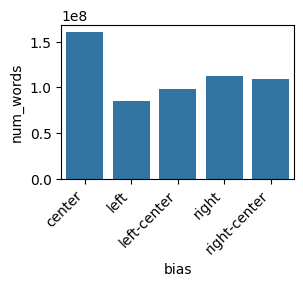

C:\Users\user\AppData\Local\Temp\ipykernel_10152\851390922.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


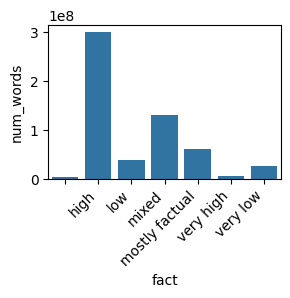

In [9]:
COLUMNS_FOR_ANALYSIS = ['bias', 'fact']
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data.groupby(COLUMN_FOR_ANALYSIS)['num_words'].sum().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.show()


In [12]:
all_data_balanced = cut(all_data, 'fact', 'high', 8)
all_data_balanced = cut(all_data_balanced, 'fact', 'mixed', 3)
all_data_balanced = cut(all_data_balanced, 'bias', 'center', 2)
all_data_balanced = cut(all_data_balanced, 'fact', 'mostly factual', 3)


Total 'Uproxx' after downsampling: 6065
Total 'Other': 40184
Total 'Uproxx' after downsampling: 8689
Total 'Other': 20182
Total 'Uproxx' after downsampling: 2196
Total 'Other': 24478
Total 'Uproxx' after downsampling: 2080
Total 'Other': 20434


In [14]:
all_data_balanced = cut(all_data_balanced, 'bias', 'right', 3)
all_data_balanced = cut(all_data_balanced, 'fact', 'mixed', 2)


Total 'Uproxx' after downsampling: 2859
Total 'Other': 13937
Total 'Uproxx' after downsampling: 3766
Total 'Other': 9263


C:\Users\user\AppData\Local\Temp\ipykernel_10152\1213507259.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


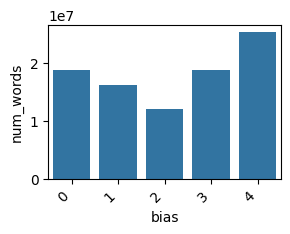

C:\Users\user\AppData\Local\Temp\ipykernel_10152\1213507259.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


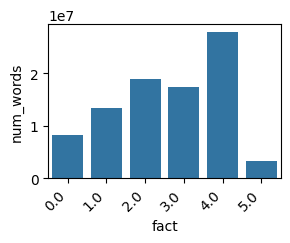

TypeError: unhashable type: 'list'

In [17]:
COLUMNS_FOR_ANALYSIS = ['bias', 'fact', 'bias_fact']
for COLUMN_FOR_ANALYSIS in COLUMNS_FOR_ANALYSIS:
    avg_words_by_COLUMN_FOR_ANALYSIS = all_data_balanced.groupby(COLUMN_FOR_ANALYSIS)['num_words'].sum().reset_index()
    plt.figure(figsize=(3, 2))
    ax = sns.barplot(data=avg_words_by_COLUMN_FOR_ANALYSIS, x=COLUMN_FOR_ANALYSIS, y='num_words')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.show()

In [16]:
label_bias_order_mapping = {
    "left": 0,
    "left-center": 1,
    "center": 2,
    "right-center": 3,
    "right": 4
}

label_fact_order_mapping = {
    "very low": 0,
    "low": 1,
    "mixed": 2,
    "mostly factual": 3,
    "high": 4,
    "very high" : 5
}

all_data_balanced['bias'] = all_data_balanced['bias'].map(label_bias_order_mapping)
all_data_balanced['fact'] = all_data_balanced['fact'].map(label_fact_order_mapping)
all_data_balanced['bias_fact'] =  all_data_balanced.apply(lambda row: [row['bias'], row['fact']], axis=1)

In [18]:
all_data_balanced.head()


,name,fact,bias,text,id,num_words,bias_fact
27017,Orlando Standard,2.0,3,Olympic Team Trials – Marathon UpdateU. Olym...,0913a223,1244,"[3, 2.0]"
30423,SC Connecticut News,2.0,3,Norwalk doctor: 'The biggest goal of treating ...,06f46b20,2665,"[3, 2.0]"
21833,Monterey Times,2.0,3,Power Yoga w/ Monterey Bay Moves on March 21Po...,d9ecfca8,862,"[3, 2.0]"
34082,Tallahassee Sun,2.0,3,Gaetz calls for passage of Free Speech Protec...,7dda1c9e,3132,"[3, 2.0]"
15704,Hopkinsville Times,2.0,3,How many points did Sophia Maddux from Hopkins...,31dc29f4,1238,"[3, 2.0]"


In [19]:
def clean_text_vectorized(text_series):
    # Remove URLs
    text_no_urls = text_series.str.replace(r'http\S+|www\.\S+', '', regex=True)
    # Remove punctuation marks
    text_no_punctuation = text_no_urls.str.replace(r'[^\w\s]', '', regex=True)
    # Remove HTML
    text_no_html = text_no_punctuation.str.replace(r'<.*?>', '', regex=True)
    return text_no_html

all_data_balanced['text'] = clean_text_vectorized(all_data_balanced['text'])

In [20]:
def clean_text_vectorized(text_series):
    # Remove URLs
    text_no_urls = text_series.str.replace(r'http\S+|www\.\S+', '', regex=True)
    # Remove punctuation marks
    text_no_punctuation = text_no_urls.str.replace(r'[^\w\s]', '', regex=True)
    # Remove HTML
    text_no_html = text_no_punctuation.str.replace(r'<.*?>', '', regex=True)
    return text_no_html

def tokenize_and_chunk(text, tokenizer, max_chunk_length=256):
    # Tokenize the text without converting to IDs yet to properly handle chunking with special tokens
    tokenized_text = tokenizer.tokenize(text)
    # Initialize an empty list to store token ID chunks
    chunks = []
    # Calculate the actual chunk length accounting for special tokens
    adjusted_chunk_length = max_chunk_length - 2  # Subtracting the space for [CLS] and [SEP]
    for i in range(0, len(tokenized_text), adjusted_chunk_length):
        # Extract the chunk of tokenized text
        chunk = tokenized_text[i:i + adjusted_chunk_length]
        # Convert chunk to IDs with special tokens
        chunk_ids = tokenizer.convert_tokens_to_ids(['[CLS]'] + chunk + ['[SEP]'])
        #padding
        padding_length = max_chunk_length - len(chunk_ids)
        chunk_ids.extend([tokenizer.pad_token_id] * padding_length)
        chunks.append(chunk_ids)
    return chunks

def ids_to_tokens(ids, tokenizer):
    token = tokenizer.convert_ids_to_tokens(ids)
    return token

def create_attention_masks(input_ids):
    return [[float(i > 0) for i in seq] for seq in input_ids]

In [21]:
all_data_distilbert= all_data_balanced.copy()
tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
expanded_rows = []
total_rows = all_data_distilbert.shape[0]

for _, row in tqdm(all_data_distilbert.iloc[0:total_rows,:].iterrows(), total=total_rows):
    chunks = tokenize_and_chunk(row['text'], tokenizer_distilbert)
    for chunk in chunks:
        expanded_rows.append({'name': row['name'], 'bias': row['bias'], 'fact': row['fact'], 'bias_fact': row['bias_fact'], 'text_chunk' : chunk})

distilbert_all_data_ids = pd.DataFrame(expanded_rows)
distilbert_all_data_ids.to_csv('D://DL_coursework//task1//2728//distilbert.csv', index=False)

100%|██████████| 13029/13029 [24:02<00:00,  9.03it/s] 


In [22]:
all_data_bert= all_data_balanced.copy()
tokenizer_bert = BertTokenizer.from_pretrained('bert-large-uncased')
expanded_rows = []
total_rows = all_data_bert.shape[0]

for _, row in tqdm(all_data_bert.iloc[0:total_rows,:].iterrows(), total=total_rows):
    chunks = tokenize_and_chunk(row['text'], tokenizer_bert)
    for chunk in chunks:
        expanded_rows.append({'name': row['name'], 'bias': row['bias'], 'fact': row['fact'], 'bias_fact': row['bias_fact'], 'text_chunk' : chunk})

bert_all_data_ids = pd.DataFrame(expanded_rows)
bert_all_data_ids.to_csv('D://DL_coursework//task1//2728//bert.csv', index=False)

100%|██████████| 13029/13029 [24:54<00:00,  8.72it/s] 


In [23]:
all_data_roberta= all_data_balanced.copy()
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-large')
expanded_rows = []
total_rows = all_data_roberta.shape[0]

for _, row in tqdm(all_data_roberta.iloc[0:total_rows,:].iterrows(), total=total_rows):
    chunks = tokenize_and_chunk(row['text'], tokenizer_roberta)
    for chunk in chunks:
        expanded_rows.append({'name': row['name'], 'bias': row['bias'], 'fact': row['fact'], 'bias_fact': row['bias_fact'], 'text_chunk' : chunk})

roberta_all_data_ids = pd.DataFrame(expanded_rows)
roberta_all_data_ids.to_csv('D://DL_coursework//task1//2728//roberta.csv', index=False)

100%|██████████| 13029/13029 [08:40<00:00, 25.01it/s]


In [ ]:
proportions_bias = test_bias['bias'].value_counts(normalize=True)
print("proportions for'bias':")
print(proportions_bias)

proportions_fact = test_bias['fact'].value_counts(normalize=True)
print("\proportions for 'fact':")
print(proportions_fact)

proportions_bias_fact = test_bias['bias_fact'].value_counts(normalize=True)
print("\nproportions for 'bias_fact':")
print(proportions_bias_fact)

proportions for'bias':
bias
4    0.293204
3    0.277670
2    0.176375
0    0.126537
1    0.126214
Name: proportion, dtype: float64
\proportions for 'fact':
fact
2.0    0.290850
4.0    0.255229
3.0    0.221895
1.0    0.133660
0.0    0.078105
5.0    0.020261
Name: proportion, dtype: float64

proportions for 'bias_fact':
bias_fact
[3, 2.0]    0.176052
[2, 4.0]    0.136246
[4, 1.0]    0.126861
[4, 0.0]    0.077346
[0, 3.0]    0.066667
[4, 2.0]    0.062136
[3, 3.0]    0.056311
[1, 4.0]    0.055016
[1, 3.0]    0.053722
[3, 4.0]    0.044660
[0, 2.0]    0.033010
[2, 3.0]    0.022330
[4, 3.0]    0.020712
[0, 4.0]    0.016505
[2, 5.0]    0.015210
[1, 2.0]    0.014239
[0, 1.0]    0.004854
[1, 5.0]    0.003236
[2, 2.0]    0.002589
[0, 5.0]    0.001618
[3, 1.0]    0.000647
[4, nan]    0.000324
[4, nan]    0.000324
[0, nan]    0.000324
[0, nan]    0.000324
[0, nan]    0.000324
[4, nan]    0.000324
[0, nan]    0.000324
[4, nan]    0.000324
[0, nan]    0.000324
[4, nan]    0.000324
[0, nan]    0.00032

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
C:\Users\user\AppData\Local\Temp\ipykernel_7964\3301733064.py:6: SyntaxWarning: invalid escape sequence '\p'
  print("\proportions for 'fact':")
